# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import the libraries you will be using for analysis
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [6]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print ("numpy version:", np.__version__)
print ("pandas version:", pd.__version__)
print ("matplotlib version:", plt.matplotlib.__version__)
print ("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [ ]:
# Try loading one file
df_parquet = pd.read_parquet ('datasets_and_dictionary/trip_records/2023-1.parquet')

df_parquet.info ()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [ ]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
% Skip this cell in order to avoid regenration of sampled file
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

file_list = {
    "datasets_and_dictionary/trip_records/2023-1.parquet",
    "datasets_and_dictionary/trip_records/2023-2.parquet",
    "datasets_and_dictionary/trip_records/2023-3.parquet",
    "datasets_and_dictionary/trip_records/2023-4.parquet",
    "datasets_and_dictionary/trip_records/2023-5.parquet",
    "datasets_and_dictionary/trip_records/2023-6.parquet",
    "datasets_and_dictionary/trip_records/2023-7.parquet",
    "datasets_and_dictionary/trip_records/2023-8.parquet",
    "datasets_and_dictionary/trip_records/2023-9.parquet",
    "datasets_and_dictionary/trip_records/2023-10.parquet",
    "datasets_and_dictionary/trip_records/2023-11.parquet",
    "datasets_and_dictionary/trip_records/2023-12.parquet"}    

# initialise an empty dataframe
df = pd.DataFrame ()

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # Reading the current file
        df_month = pd.read_parquet (file_name)

        # Add day column for grouping and iteration
        df_month['pickup_month_day'] = df_month['tpep_pickup_datetime'].apply (lambda x : x.day)

        # Add hour column for grouping and iteration
        df_month['pickup_hour'] = df_month['tpep_pickup_datetime'].apply (lambda x : x.hour)

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame ()
           
        df_day_grouped = df_month.groupby ("pickup_month_day");
        
        # Loop through dates and then loop through every hour of each date
        for day_name, day_group in df_day_grouped:            
            # Iterate through each hour of the selected date
            df_hour_grouped = day_group.groupby ("pickup_hour");

            for hour_name, hour_group in df_hour_grouped:
                # Sample 1% of the hourly data randomly
                sample = hour_group.sample (frac = 0.01, random_state = 77)
                
                # add data of this hour to the dataframe
                sampled_data = pd.concat ([sampled_data, sample])
                
        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat ([df, sampled_data])

    except Exception as e:
        print (f"Error reading file {file_name}: {e}")

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
% Skip this cell in order to avoid regenration of sampled file
# Store the df in csv/parquet
df.to_csv ('sampled_trip_records.csv')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [209]:
# Load the new data file
df = pd.read_csv ('sampled_trip_records.csv', index_col=0)

# Convert tpep_pickup_datetime to datetime64[us]
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].astype ('datetime64[us]')

# Convert tpep_dropoff_datetime to datetime64[us]
df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].astype ('datetime64[us]')

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [213]:
# Fix the index and drop any columns that are not needed

# Reset index
df.reset_index (drop=True, inplace=True)

# Drop Unnamed, pickup_month_day and pickup_hour column
df.drop (columns=['store_and_fwd_flag'], inplace=True)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [216]:
# Combine the two airport fee columns

# Set NAN to 0
df['Airport_fee'].fillna (0, inplace=True)

# Set NAN to 0
df['airport_fee'].fillna (0, inplace=True)

# Retain airport fee which is higher
df['airport_fee'] = np.where ((df['Airport_fee'] >= df['airport_fee']), df['Airport_fee'], df['airport_fee'])

# Drop the other airport fee column
df.drop (columns=['Airport_fee'], inplace=True)

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [219]:
# check where values of fare amount are negative
(df['total_amount'] < 0).any().any()

True

Did you notice something different in the `RatecodeID` column for above records?

In [222]:
# Analyse RatecodeID for the negative fare amounts
df[df['total_amount'] < 0]['RatecodeID']

6448      1.0
44615     2.0
52284     1.0
70716     1.0
86039     1.0
87411     5.0
99538     1.0
105475    1.0
107588    1.0
121515    3.0
134184    1.0
140132    3.0
154055    1.0
162940    2.0
168653    2.0
183266    1.0
209320    1.0
219147    2.0
221028    1.0
308620    1.0
316134    1.0
351216    2.0
368613    2.0
Name: RatecodeID, dtype: float64

In [224]:
# Find which columns have negative values
columns = {
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'congestion_surcharge',
    'airport_fee'}

for column in columns:
    print ("{0} {1}".format (column, (df[column] < 0).any().any()))

total_amount True
fare_amount False
tip_amount False
tolls_amount False
mta_tax True
improvement_surcharge True
congestion_surcharge True
extra False
airport_fee False


In [226]:
# fix these negative values

# Set congestion_surcharge to zero whenever fare_amount is zero
df.loc[df['fare_amount'] == 0, 'congestion_surcharge'] = 0

# Set total_amount to zero whenever fare_amount is zero
df.loc[df['fare_amount'] == 0, 'total_amount'] = 0

# Set mta_tax to zero whenever fare_amount is zero
df.loc[df['fare_amount'] == 0, 'mta_tax'] = 0

# Set improvement_surcharge to zero whenever fare_amount is zero
df.loc[df['fare_amount'] == 0, 'improvement_surcharge'] = 0

# Check negative value again
for column in columns:
    print ("{0} {1}".format (column, (df[column] < 0).any().any()))

total_amount False
fare_amount False
tip_amount False
tolls_amount False
mta_tax False
improvement_surcharge False
congestion_surcharge False
extra False
airport_fee False


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [230]:
# Find the proportion of missing values in each column
for column in df:
    print ("{0} -> {1:0.2f} %".format(column, df[column].isna ().sum () * 100.0 / df.shape [0]))

VendorID -> 0.00 %
tpep_pickup_datetime -> 0.00 %
tpep_dropoff_datetime -> 0.00 %
passenger_count -> 3.21 %
trip_distance -> 0.00 %
RatecodeID -> 3.21 %
PULocationID -> 0.00 %
DOLocationID -> 0.00 %
payment_type -> 0.00 %
fare_amount -> 0.00 %
extra -> 0.00 %
mta_tax -> 0.00 %
tip_amount -> 0.00 %
tolls_amount -> 0.00 %
improvement_surcharge -> 0.00 %
total_amount -> 0.00 %
congestion_surcharge -> 3.21 %
pickup_month_day -> 0.00 %
pickup_hour -> 0.00 %
airport_fee -> 0.00 %


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [233]:
# Display the rows with null values
df [df['passenger_count'].isnull()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
30             2  2023-07-01 00:57:54   2023-07-01 01:18:33              NaN   
38             2  2023-07-01 01:03:00   2023-07-01 01:20:00              NaN   
58             2  2023-07-01 01:38:19   2023-07-01 01:47:39              NaN   
111            2  2023-07-01 04:56:35   2023-07-01 05:10:10              NaN   
137            2  2023-07-01 07:46:53   2023-07-01 08:30:08              NaN   
...          ...                  ...                   ...              ...   
379102         2  2023-03-31 21:01:23   2023-03-31 21:12:55              NaN   
379133         1  2023-03-31 21:39:15   2023-03-31 21:42:41              NaN   
379161         1  2023-03-31 22:52:27   2023-03-31 23:06:22              NaN   
379173         2  2023-03-31 22:10:54   2023-03-31 22:23:49              NaN   
379220         2  2023-03-31 23:29:00   2023-03-31 23:48:00              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
30               5.38         NaN           249            61             0   
38               4.98         NaN           144           239             0   
58               1.99         NaN           249           170             0   
111              9.03         NaN           263           138             0   
137             19.58         NaN           141             1             0   
...               ...         ...           ...           ...           ...   
379102           1.37         NaN            79           249             0   
379133           0.70         NaN           229           140             0   
379161           2.90         NaN           164           236             0   
379173           2.01         NaN           209           114             0   
379220           3.31         NaN           230           145             0   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
30            27.80    0.0      0.5        6.36          0.00   
38            30.28    0.0      0.5        6.86          0.00   
58            13.06    0.0      0.5        2.00          0.00   
111           26.21    0.0      0.5        0.00          6.55   
137           89.38    0.0      0.0       12.00         12.75   
...             ...    ...      ...         ...           ...   
379102        10.44    0.0      0.5        0.00          0.00   
379133         5.80    1.0      0.5        1.62          0.00   
379161        15.60    1.0      0.5        3.09          0.00   
379173        15.05    0.0      0.5        2.00          0.00   
379220        17.89    0.0      0.5        3.28          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
30                        1.0         38.16                   NaN   
38                        1.0         41.14                   NaN   
58                        1.0         19.06                   NaN   
111                       1.0         36.76                   NaN   
137                       1.0        115.13                   NaN   
...                       ...           ...                   ...   
379102                    1.0         14.44                   NaN   
379133                    1.0         12.42                   NaN   
379161                    1.0         23.69                   NaN   
379173                    1.0         21.05                   NaN   
379220                    1.0         25.17                   NaN   

        pickup_month_day  pickup_hour  airport_fee  
30                     1            0          0.0  
38                     1            1          0.0  
58                     1            1          0.0  
111                    1            4          0.0  
137                    1            7          0.0  
...                  ...          ...          ...  
379102                31           21          0.0  
379133                31           21          0.0  
379161     

In [235]:
df [df['RatecodeID'].isnull()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
30             2  2023-07-01 00:57:54   2023-07-01 01:18:33              NaN   
38             2  2023-07-01 01:03:00   2023-07-01 01:20:00              NaN   
58             2  2023-07-01 01:38:19   2023-07-01 01:47:39              NaN   
111            2  2023-07-01 04:56:35   2023-07-01 05:10:10              NaN   
137            2  2023-07-01 07:46:53   2023-07-01 08:30:08              NaN   
...          ...                  ...                   ...              ...   
379102         2  2023-03-31 21:01:23   2023-03-31 21:12:55              NaN   
379133         1  2023-03-31 21:39:15   2023-03-31 21:42:41              NaN   
379161         1  2023-03-31 22:52:27   2023-03-31 23:06:22              NaN   
379173         2  2023-03-31 22:10:54   2023-03-31 22:23:49              NaN   
379220         2  2023-03-31 23:29:00   2023-03-31 23:48:00              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
30               5.38         NaN           249            61             0   
38               4.98         NaN           144           239             0   
58               1.99         NaN           249           170             0   
111              9.03         NaN           263           138             0   
137             19.58         NaN           141             1             0   
...               ...         ...           ...           ...           ...   
379102           1.37         NaN            79           249             0   
379133           0.70         NaN           229           140             0   
379161           2.90         NaN           164           236             0   
379173           2.01         NaN           209           114             0   
379220           3.31         NaN           230           145             0   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
30            27.80    0.0      0.5        6.36          0.00   
38            30.28    0.0      0.5        6.86          0.00   
58            13.06    0.0      0.5        2.00          0.00   
111           26.21    0.0      0.5        0.00          6.55   
137           89.38    0.0      0.0       12.00         12.75   
...             ...    ...      ...         ...           ...   
379102        10.44    0.0      0.5        0.00          0.00   
379133         5.80    1.0      0.5        1.62          0.00   
379161        15.60    1.0      0.5        3.09          0.00   
379173        15.05    0.0      0.5        2.00          0.00   
379220        17.89    0.0      0.5        3.28          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
30                        1.0         38.16                   NaN   
38                        1.0         41.14                   NaN   
58                        1.0         19.06                   NaN   
111                       1.0         36.76                   NaN   
137                       1.0        115.13                   NaN   
...                       ...           ...                   ...   
379102                    1.0         14.44                   NaN   
379133                    1.0         12.42                   NaN   
379161                    1.0         23.69                   NaN   
379173                    1.0         21.05                   NaN   
379220                    1.0         25.17                   NaN   

        pickup_month_day  pickup_hour  airport_fee  
30                     1            0          0.0  
38                     1            1          0.0  
58                     1            1          0.0  
111                    1            4          0.0  
137                    1            7          0.0  
...                  ...          ...          ...  
379102                31           21          0.0  
379133                31           21          0.0  
379161     

In [237]:
df [df['congestion_surcharge'].isnull()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
30             2  2023-07-01 00:57:54   2023-07-01 01:18:33              NaN   
38             2  2023-07-01 01:03:00   2023-07-01 01:20:00              NaN   
58             2  2023-07-01 01:38:19   2023-07-01 01:47:39              NaN   
111            2  2023-07-01 04:56:35   2023-07-01 05:10:10              NaN   
137            2  2023-07-01 07:46:53   2023-07-01 08:30:08              NaN   
...          ...                  ...                   ...              ...   
379102         2  2023-03-31 21:01:23   2023-03-31 21:12:55              NaN   
379133         1  2023-03-31 21:39:15   2023-03-31 21:42:41              NaN   
379161         1  2023-03-31 22:52:27   2023-03-31 23:06:22              NaN   
379173         2  2023-03-31 22:10:54   2023-03-31 22:23:49              NaN   
379220         2  2023-03-31 23:29:00   2023-03-31 23:48:00              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
30               5.38         NaN           249            61             0   
38               4.98         NaN           144           239             0   
58               1.99         NaN           249           170             0   
111              9.03         NaN           263           138             0   
137             19.58         NaN           141             1             0   
...               ...         ...           ...           ...           ...   
379102           1.37         NaN            79           249             0   
379133           0.70         NaN           229           140             0   
379161           2.90         NaN           164           236             0   
379173           2.01         NaN           209           114             0   
379220           3.31         NaN           230           145             0   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
30            27.80    0.0      0.5        6.36          0.00   
38            30.28    0.0      0.5        6.86          0.00   
58            13.06    0.0      0.5        2.00          0.00   
111           26.21    0.0      0.5        0.00          6.55   
137           89.38    0.0      0.0       12.00         12.75   
...             ...    ...      ...         ...           ...   
379102        10.44    0.0      0.5        0.00          0.00   
379133         5.80    1.0      0.5        1.62          0.00   
379161        15.60    1.0      0.5        3.09          0.00   
379173        15.05    0.0      0.5        2.00          0.00   
379220        17.89    0.0      0.5        3.28          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
30                        1.0         38.16                   NaN   
38                        1.0         41.14                   NaN   
58                        1.0         19.06                   NaN   
111                       1.0         36.76                   NaN   
137                       1.0        115.13                   NaN   
...                       ...           ...                   ...   
379102                    1.0         14.44                   NaN   
379133                    1.0         12.42                   NaN   
379161                    1.0         23.69                   NaN   
379173                    1.0         21.05                   NaN   
379220                    1.0         25.17                   NaN   

        pickup_month_day  pickup_hour  airport_fee  
30                     1            0          0.0  
38                     1            1          0.0  
58                     1            1          0.0  
111                    1            4          0.0  
137                    1            7          0.0  
...                  ...          ...          ...  
379102                31           21          0.0  
379133                31           21          0.0  
379161     

Did you find zeroes in passenger_count? Handle these.

In [240]:
# Drop rows, with zero passenger counts
df.drop (df[(df['passenger_count'] == 0)].index, inplace=True)

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [243]:
# Fix missing values in 'RatecodeID'
df.drop (df[df['RatecodeID'].isna ()].index, inplace=True)

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [246]:
# handle null values in congestion_surcharge
congestion_surcharge_mode = df['congestion_surcharge'].mode ()

df.loc[df['congestion_surcharge'].isna (), 'congestion_surcharge'] = congestion_surcharge_mode[0]

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [249]:
# Handle any remaining missing values
df.info ()

<class 'pandas.core.frame.DataFrame'>
Index: 361484 entries, 0 to 379269
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               361484 non-null  int64         
 1   tpep_pickup_datetime   361484 non-null  datetime64[us]
 2   tpep_dropoff_datetime  361484 non-null  datetime64[us]
 3   passenger_count        361484 non-null  float64       
 4   trip_distance          361484 non-null  float64       
 5   RatecodeID             361484 non-null  float64       
 6   PULocationID           361484 non-null  int64         
 7   DOLocationID           361484 non-null  int64         
 8   payment_type           361484 non-null  int64         
 9   fare_amount            361484 non-null  float64       
 10  extra                  361484 non-null  float64       
 11  mta_tax                361484 non-null  float64       
 12  tip_amount             361484 non-null  float64  

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [253]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
#df['payment_type'].describe ()
#df['trip_distance'].unique ()
#df['passenger_count'].unique ()
#df['RatecodeID'].unique ()
#df['payment_type'].unique ()
#df[(df['payment_type'] == 3) & (df['fare_amount'] == 0)]
#df[(df['fare_amount'] > 200) & (df['trip_distance'] < 10)]
#df['fare_amount'].plot.box () #quantile (0.99)
#plt.show ()
#df[df['fare_amount'] > 40].count ()
#df['total_amount'].quantile (0.99)
#df['airport_fee'].describe ()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [258]:
# remove passenger_count > 6
df.drop (df[(df['passenger_count'] > 6)].index, inplace=True)

In [260]:
# Continue with outlier handling

# Remove rows with RatecodeID 99
df.drop (df[(df['RatecodeID'] == 99)].index, inplace=True)

# Remove rows where payment type is equal to 0
df.drop (df[(df['payment_type'] == 0)].index, inplace=True)

# Remove rows where payment_type is 3 (no_charge) but fare_amount is non zero
df.drop (df[(df['payment_type'] == 3) & (df['fare_amount'] > 0)].index, inplace=True)

# 0.1% of data is having fare_amount < 3.0. Drop rows having fare_amount < 3.0
df.drop (df[(df['fare_amount'] < 3.0)].index, inplace=True)

# 99.9% of data is having fare_amount < 149.41. Drop rows having fare_amount > 149.41
df.drop (df[(df['fare_amount'] > 149.41)].index, inplace=True)

# 99.9% of data is having tip_amount < 30. Drop rows having tip_amount > 30
df.drop (df[(df['tip_amount'] > 30)].index, inplace=True)

# 99.9% of data is having tolls_amount < 20.95. Drop rows having tolls_amount > 20.95
df.drop (df[(df['tolls_amount'] > 20.95)].index, inplace=True)

# Remove rows where tpep_dropoff_datetime is earlier to tpep_pickup_datetime
df.drop (df[(df['tpep_dropoff_datetime'] <= df['tpep_pickup_datetime'])].index, inplace=True)

# Remove rows where trip duration is less than 69 seconds
df.drop (df[((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds () < 69)].index, inplace=True)

# Remove rows where trip duration is more than 7796.56 seconds
df.drop (df[((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds () > 7796.56)].index, inplace=True)

# Drop rows having trip_distance less than 0.6 miles
df.drop (df[(df['trip_distance'] < 0.6)].index, inplace=True)

# Drop rows having trip_distance more than 250 miles
df.drop (df[(df['trip_distance'] > 250)].index, inplace=True)

In [261]:
# Do any columns need standardising?

# Set pickup year to 2023
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].apply (lambda x : x.replace (year = 2023))

# Set dropoff year to 2023
df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].apply (lambda x : x if x.year == 2023 or x.year == 2024 else x.replace (year = 2023))

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [264]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_month_day',
 'pickup_hour',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [269]:
# Generate pickup day of the week
df['pickup_week_day'] = df['tpep_pickup_datetime'].apply (lambda x : x.dayofweek)

# Generate pickup month
df['pickup_month'] = df['tpep_pickup_datetime'].apply (lambda x : x.month)

In [270]:
df.columns.tolist ()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'pickup_month_day',
 'pickup_hour',
 'airport_fee',
 'pickup_week_day',
 'pickup_month']

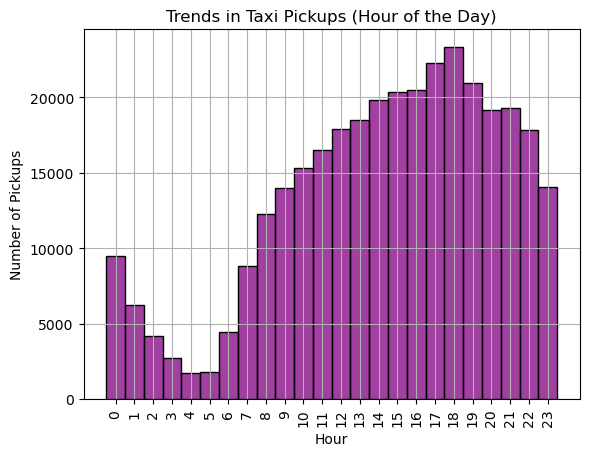

In [271]:
# Find and show the hourly trends in taxi pickups
h = sns.histplot (data=df, x="pickup_hour", discrete=True, color='purple')
plt.title ('Trends in Taxi Pickups (Hour of the Day)')
plt.ylabel ("Number of Pickups")
plt.xlabel ("Hour")
h.set_xticks ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
plt.xticks (rotation=90)
plt.grid (True)
plt.show ()

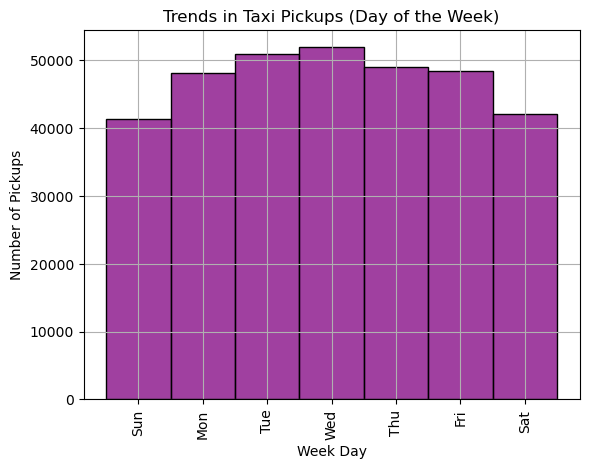

In [272]:
h = sns.histplot (data=df, x="pickup_week_day", discrete=True, color='purple')
plt.title ('Trends in Taxi Pickups (Day of the Week)')
plt.ylabel ("Number of Pickups")
plt.xlabel ("Week Day")
h.set_xticks ([0, 1, 2, 3, 4, 5, 6])
h.set_xticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xticks (rotation=90)
plt.grid (True)
plt.show ()

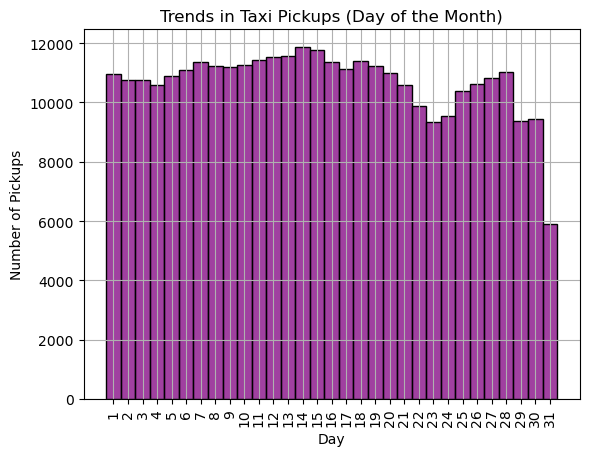

In [273]:
# Find and show the daily trends in taxi pickups (days of the week)
h = sns.histplot (data=df, x="pickup_month_day", discrete=True, color='purple')
plt.title ('Trends in Taxi Pickups (Day of the Month)')
plt.ylabel ("Number of Pickups")
plt.xlabel ("Day")
h.set_xticks ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
plt.xticks (rotation=90)
plt.grid (True)
plt.show ()

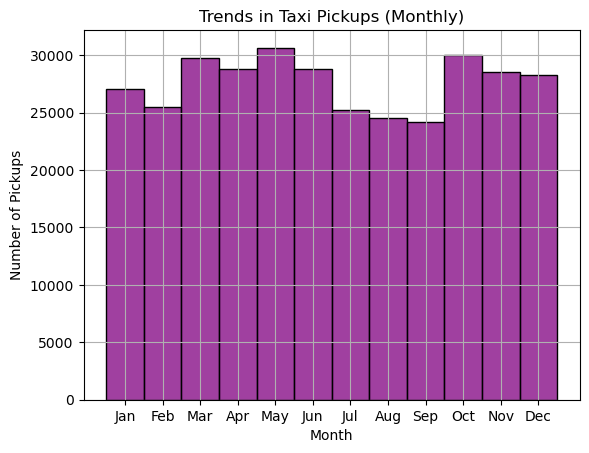

In [274]:
# Show the monthly trends in pickups
h = sns.histplot (data=df, x="pickup_month", discrete=True, color='purple')
plt.title ('Trends in Taxi Pickups (Monthly)')
plt.ylabel ("Number of Pickups")
plt.xlabel ("Month")
h.set_xticks ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
h.set_xticklabels (["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid (True)
plt.show ()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

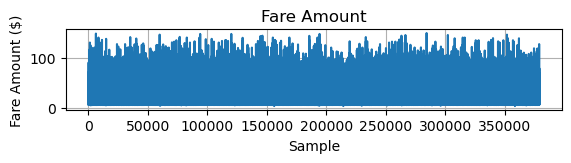

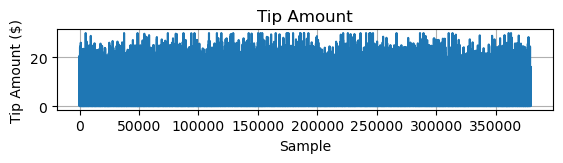

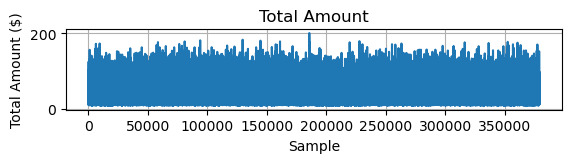

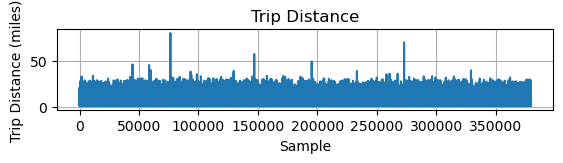

In [277]:
# Analyse the above parameters
plt.subplot (4, 1, 1)
df['fare_amount'].plot ()
plt.title ('Fare Amount')
plt.ylabel ("Fare Amount ($)")
plt.xlabel ("Sample")
plt.grid (True)
plt.show ()

plt.subplot (4, 1, 2)
df['tip_amount'].plot ()
plt.title ('Tip Amount')
plt.ylabel ("Tip Amount ($)")
plt.xlabel ("Sample")
plt.grid (True)
plt.show ()

plt.subplot (4, 1, 3)
df['total_amount'].plot ()
plt.title ('Total Amount')
plt.ylabel ("Total Amount ($)")
plt.xlabel ("Sample")
plt.grid (True)
plt.show ()

plt.subplot (4, 1, 3)
df['trip_distance'].plot ()
plt.title ('Trip Distance')
plt.ylabel ("Trip Distance (miles)")
plt.xlabel ("Sample")
plt.grid (True)
plt.show ()

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [282]:
# Create a df with non zero entries for the selected parameters.

# Remove rows where trip_distance and fare_amount equals zero 
df1 = df.drop (df[(df['trip_distance'] == 0) & (df['fare_amount'] == 0)].index).copy (deep=True)

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

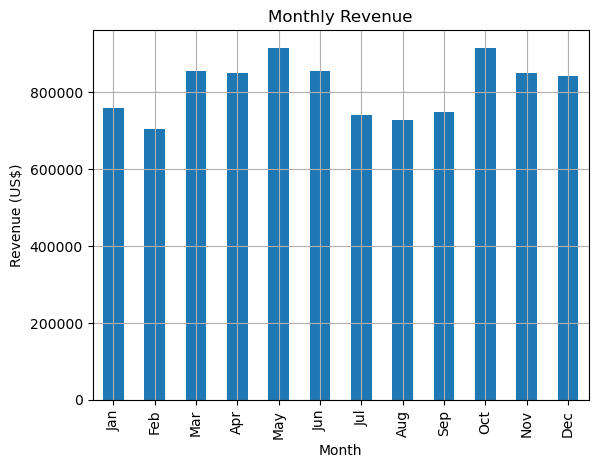

In [286]:
# Group data by month and analyse monthly revenue
h = df1.groupby ("pickup_month")['total_amount'].sum ().plot.bar ()
plt.title ('Monthly Revenue')
plt.ylabel ("Revenue (US$)")
plt.xlabel ("Month")
h.set_xticks ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
h.set_xticklabels (["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid (True)
plt.show ()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

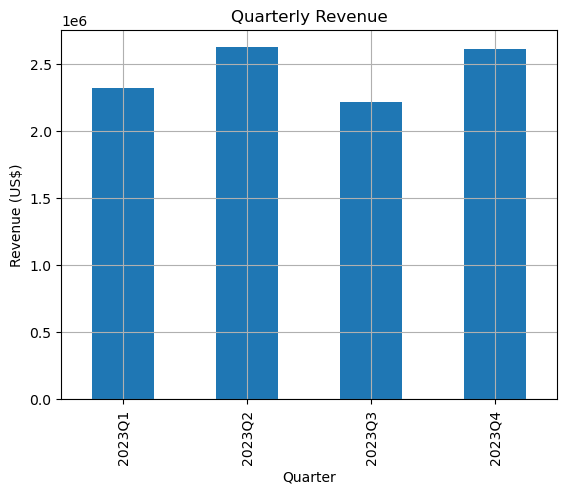

In [288]:
# Calculate proportion of each quarter
df1.groupby (df1['tpep_pickup_datetime'].dt.to_period ('Q'))['total_amount'].sum ().plot.bar ()
plt.title ('Quarterly Revenue')
plt.ylabel ("Revenue (US$)")
plt.xlabel ("Quarter")
h.set_xticks ([1, 2, 3, 4])
plt.grid (True)
plt.show ()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

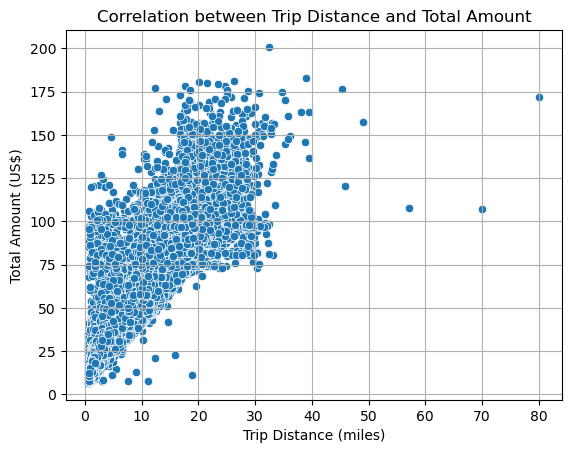

In [293]:
# Show how trip fare is affected by distance
sns.scatterplot (x="trip_distance", y="total_amount", data=df1);
plt.title ('Correlation between Trip Distance and Total Amount')
plt.ylabel ("Total Amount (US$)")
plt.xlabel ("Trip Distance (miles)")
plt.grid (True)
plt.show ()

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

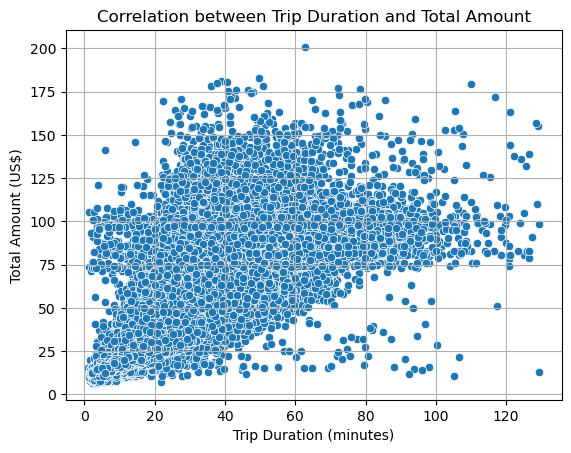

In [296]:
# Show relationship between fare and trip duration
df1['trip_duration'] = (df1['tpep_dropoff_datetime'] - df1['tpep_pickup_datetime']).dt.total_seconds () / 60.0
sns.scatterplot (x="trip_duration", y="total_amount", data=df1);
plt.title ('Correlation between Trip Duration and Total Amount')
plt.ylabel ("Total Amount (US$)")
plt.xlabel ("Trip Duration (minutes)")
plt.grid (True)
plt.show ()

In [298]:
df1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'pickup_month_day', 'pickup_hour',
       'airport_fee', 'pickup_week_day', 'pickup_month', 'trip_duration'],
      dtype='object')

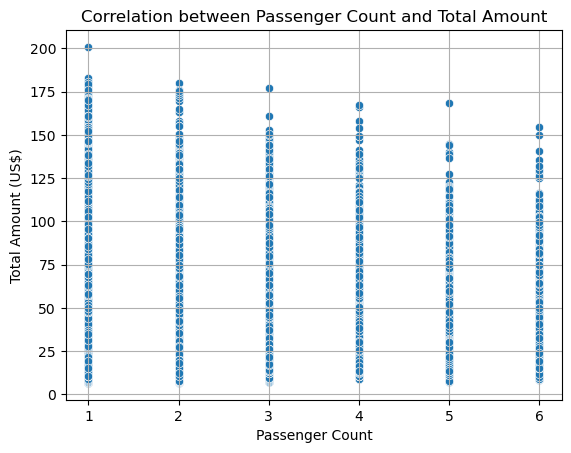

In [300]:
# Show relationship between fare and number of passengers
sns.scatterplot (x="passenger_count", y="total_amount", data=df1);
plt.title ('Correlation between Passenger Count and Total Amount')
plt.ylabel ("Total Amount (US$)")
plt.xlabel ("Passenger Count")
plt.grid (True)
plt.show ()

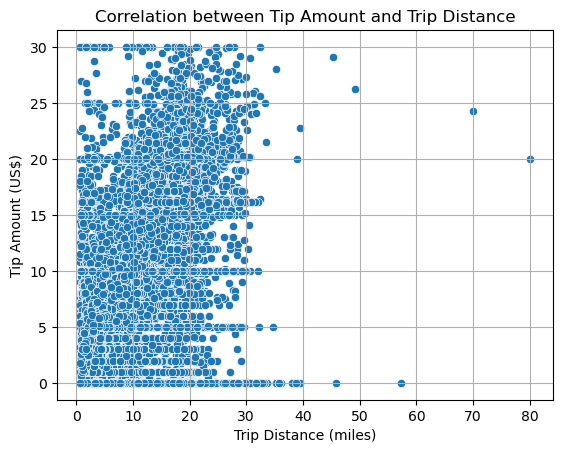

In [301]:
# Show relationship between tip and trip distance
sns.scatterplot (x="trip_distance", y="tip_amount", data=df1);
plt.title ('Correlation between Tip Amount and Trip Distance')
plt.ylabel ("Tip Amount (US$)")
plt.xlabel ("Trip Distance (miles)")
plt.grid (True)
plt.show ()

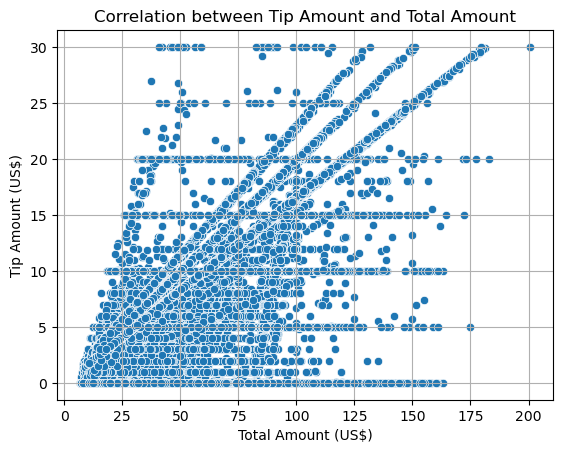

In [303]:
sns.scatterplot (x="total_amount", y="tip_amount", data=df1);
plt.title ('Correlation between Tip Amount and Total Amount')
plt.ylabel ("Tip Amount (US$)")
plt.xlabel ("Total Amount (US$)")
plt.grid (True)
plt.show ()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

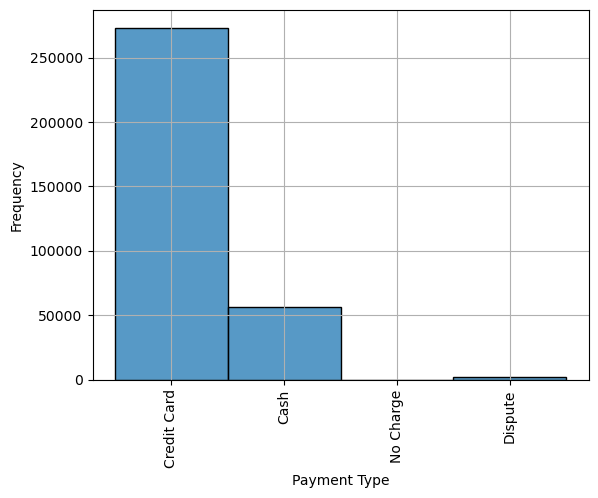

In [306]:
# Analyse the distribution of different payment types (payment_type).
h = sns.histplot (data=df1, x="payment_type", discrete=True)
plt.ylabel ("Frequency")
plt.xlabel ("Payment Type")
h.set_xticks ([1, 2, 3, 4])
h.set_xticklabels (["Credit Card", "Cash", "No Charge", "Dispute"])
plt.xticks (rotation=90)
plt.grid (True)
plt.show ()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [313]:
#!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [316]:
import geopandas as gpd

# Read the shapefile using geopandas
zones = gpd.read_file ("datasets_and_dictionary/taxi_zones/taxi_zones.shp")
zones.head ()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [319]:
zones[zones['zone'] == 'JFK Airport']

OBJECTID  Shape_Leng  Shape_Area         zone  LocationID borough  \
131       132    0.245479    0.002038  JFK Airport         132  Queens   

                                              geometry  
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...

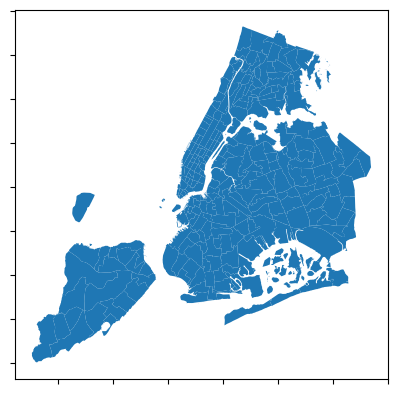

In [320]:
#print (zones.info ())
ax = zones.plot ()

# Turn off tick labels
ax.set_yticklabels ([])
ax.set_xticklabels ([])

plt.show ()

In [321]:
zones[zones['zone'] == 'JFK Airport']

OBJECTID  Shape_Leng  Shape_Area         zone  LocationID borough  \
131       132    0.245479    0.002038  JFK Airport         132  Queens   

                                              geometry  
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [325]:
# Merge zones and trip records using locationID and PULocationID
df1 = pd.merge (left=df1, right=zones[['LocationID', 'zone', 'borough']], how='left', left_on='PULocationID', right_on='LocationID')
df1.drop (columns=['LocationID'], inplace=True)
df1.rename (columns={'zone' : 'PUZone', 'borough' : 'PUBorough'}, inplace=True)
df1 = pd.merge (left=df1, right=zones[['LocationID', 'zone', 'borough']], how='left', left_on='DOLocationID', right_on='LocationID')
df1.drop (columns=['LocationID'], inplace=True)
df1.rename (columns={'zone' : 'DOZone', 'borough' : 'DOBorough'}, inplace=True)

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [335]:
# Group data by location and calculate the number of trips
df_pu_trips = df1.sort_values (['PUZone'], ascending=True).groupby ('PUZone').size ().reset_index ()
df_pu_trips.columns = ['PUZone', 'PuNbTrips']
df_do_trips = df1.sort_values (['DOZone'], ascending=True).groupby ('DOZone').size ().reset_index ()
df_do_trips.columns = ['DOZone', 'DoNbTrips']
df_trips = pd.merge (left=df_pu_trips, right=df_do_trips, how='left', left_on='PUZone', right_on='DOZone')
df_trips['NbTrips'] = df_trips['PuNbTrips'] + df_trips['DoNbTrips']
df_trips.drop (columns=['PuNbTrips'], inplace=True)
df_trips.drop (columns=['DOZone'], inplace=True)
df_trips.drop (columns=['DoNbTrips'], inplace=True)
df_trips.columns = ['zone', 'NbTrips']

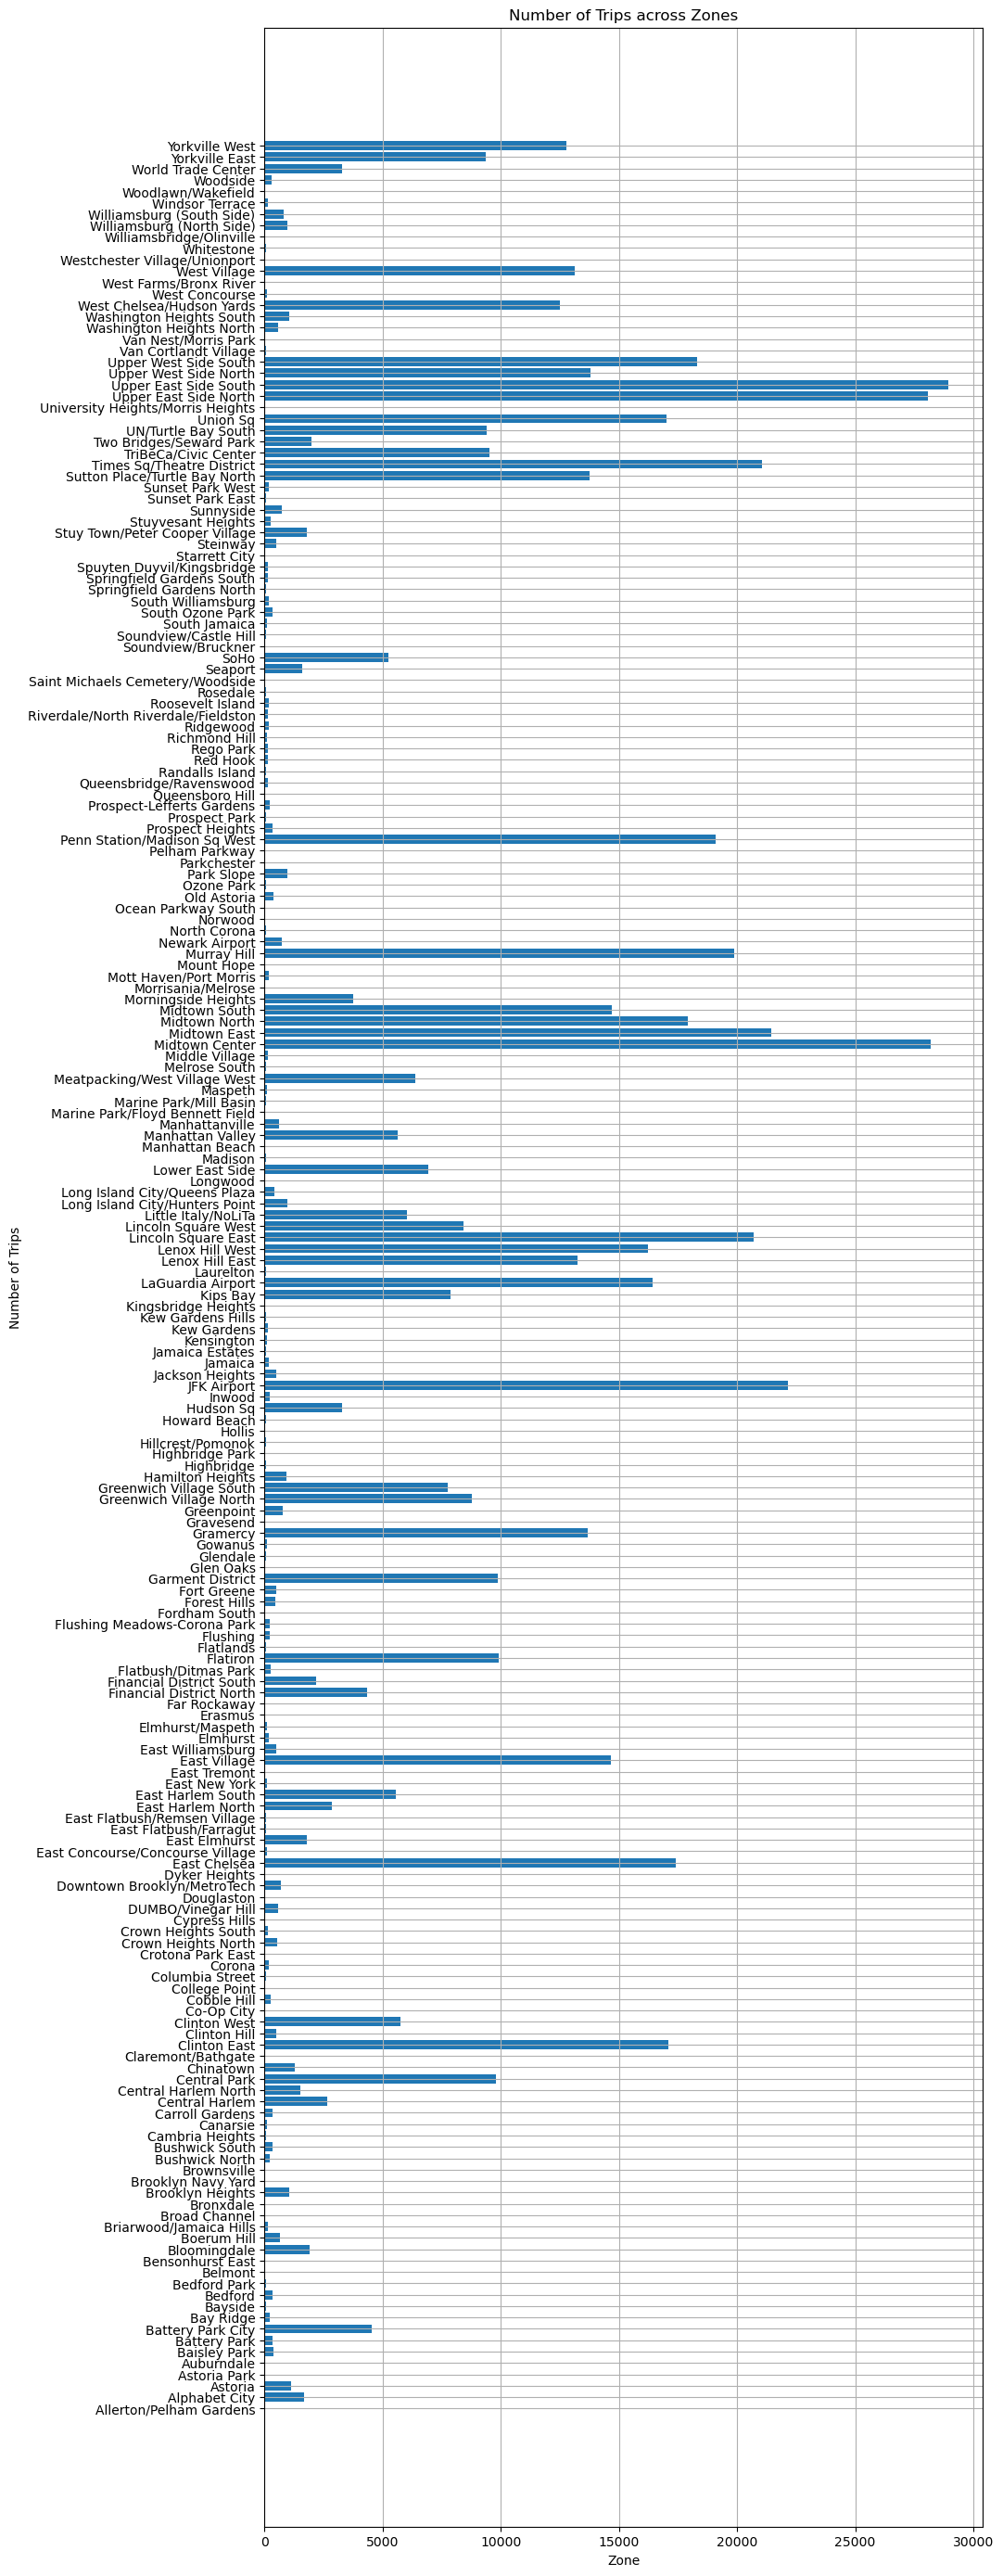

In [336]:
# Plot the number of trips for each zones
plt.figure (figsize= (10, 35))
plt.barh (df_trips['zone'], df_trips['NbTrips'])
plt.title ('Number of Trips across Zones')
plt.ylabel ("Number of Trips")
plt.xlabel ("Zone")
plt.grid (True)
plt.show ()

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [339]:
# Merge trip counts back to the zones GeoDataFrame
zones = pd.merge (left=zones, right=df_trips, how='left', left_on='zone', right_on='zone')

In [340]:
# Set NaN to zero
zones['NbTrips'].fillna (0, inplace=True)

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

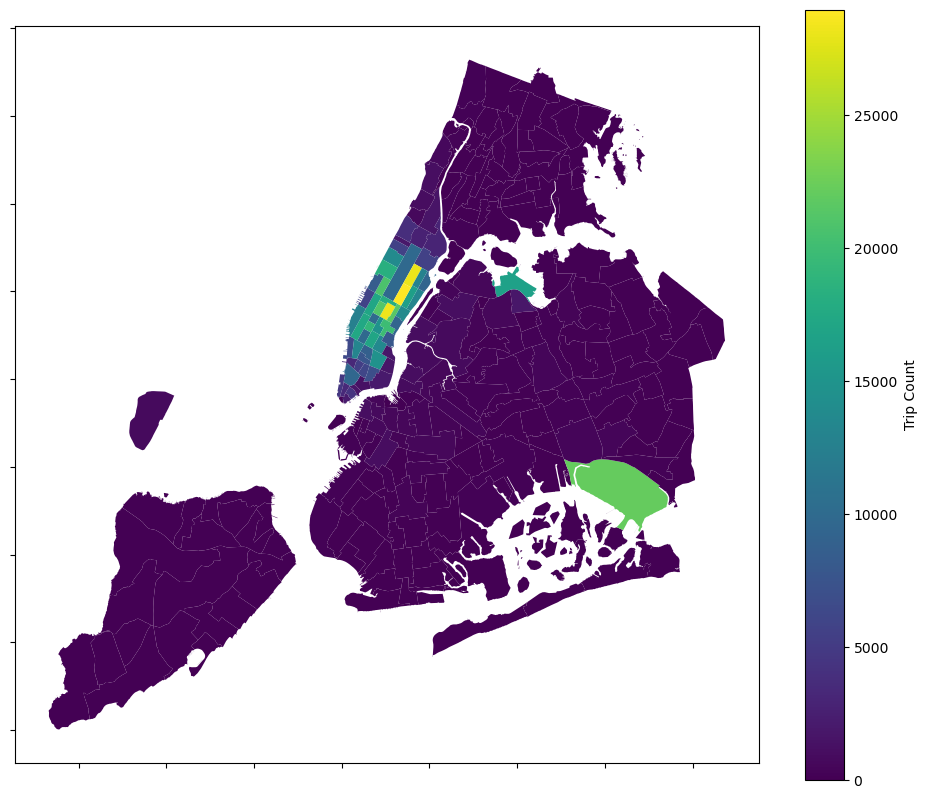

In [347]:
# Define figure and axis
fig, ax = plt.subplots (1, 1, figsize = (12, 10))

# Plot the map and display it
zones.plot (
   column = 'NbTrips',
   ax = ax,
   legend = True,
   legend_kwds = {'label': "Trip Count", 'orientation': "vertical"})

# Turn off tick labels
ax.set_yticklabels ([])
ax.set_xticklabels ([])

plt.show ()

In [349]:
# can you try displaying the zones DF sorted by the number of trips?
zones.sort_values (['NbTrips'], ascending=True)

OBJECTID  Shape_Leng  Shape_Area                   zone  LocationID  \
239       240    0.146070    0.000722     Van Cortlandt Park         240   
170       171    0.107354    0.000520     Murray Hill-Queens         171   
164       165    0.088608    0.000354                Midwood         165   
250       251    0.137711    0.000626            Westerleigh         251   
252       253    0.036051    0.000078          Willets Point         253   
..        ...         ...         ...                    ...         ...   
161       162    0.035270    0.000048           Midtown East         162   
131       132    0.245479    0.002038            JFK Airport         132   
235       236    0.044252    0.000103  Upper East Side North         236   
160       161    0.035804    0.000072         Midtown Center         161   
236       237    0.042213    0.000096  Upper East Side South         237   

           borough                                           geometry  NbTrips  
239          Bronx  POLYGON ((1018410.344 266056.29, 1018222.428 2...      0.0  
170         Queens  POLYGON ((1041536.76 220023.061, 1041527.85 21...      0.0  
164       Brooklyn  POLYGON ((995312.051 168409.655, 995365.558 16...      0.0  
250  Staten Island  POLYGON ((947868.004 169247.734, 948000.981 16...      0.0  
252         Queens  POLYGON ((1028825.348 218121.42, 1029152.461 2...      0.0  
..             ...                                                ...      ...  
161      Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...  21448.0  
131         Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...  22138.0  
235      Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...  28087.0  
160      Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...  28188.0  
236      Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...  28953.0  

[263 rows x 8 columns]

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [359]:
# Find routes which have the slowest speeds at different times of the day
df1['trip_speed'] = df1['trip_distance'] * 60.0 / df1['trip_duration']
slowest_route_df = df1.groupby (['pickup_hour', 'PUZone', 'DOZone'])['trip_speed'].mean ().reset_index (name='average_trip_speed')
slowest_route_df.loc[slowest_route_df.groupby ('pickup_hour')['average_trip_speed'].idxmin ()].reset_index (drop=True)

pickup_hour                         PUZone                     DOZone  \
0             0                Lower East Side                  Chinatown   
1             1                Lower East Side    Two Bridges/Seward Park   
2             2                        Seaport   Financial District North   
3             3                       Kips Bay                   Kips Bay   
4             4                 Midtown Center  Times Sq/Theatre District   
5             5                  Midtown North            Lenox Hill East   
6             6                  Midtown South           Garment District   
7             7      West Chelsea/Hudson Yards                   Flatiron   
8             8                   East Chelsea                       SoHo   
9             9                    Cobble Hill           Brooklyn Heights   
10           10            Lincoln Square West          East Harlem South   
11           11                    Murray Hill    Queensbridge/Ravenswood   
12           12  Sutton Place/Turtle Bay North           Roosevelt Island   
13           13                   East Village              Midtown North   
14           14                   Central Park            Lower East Side   
15           15                   Clinton East         DUMBO/Vinegar Hill   
16           16            Little Italy/NoLiTa                       SoHo   
17           17                 Yorkville West           Garment District   
18           18            Little Italy/NoLiTa                  Hudson Sq   
19           19                  College Point                 Whitestone   
20           20                       Kips Bay          LaGuardia Airport   
21           21                      Chinatown         World Trade Center   
22           22            Little Italy/NoLiTa        Lincoln Square East   
23           23               Garment District        UN/Turtle Bay South   

    average_trip_speed  
0             4.567164  
1             2.482759  
2             3.188011  
3             2.503067  
4             3.136237  
5             4.301075  
6             5.649520  
7             3.653333  
8             2.951151  
9             2.552632  
10            2.310543  
11            0.575693  
12            2.832678  
13            3.042789  
14            3.511777  
15            1.401284  
16            2.060606  
17            2.451892  
18            2.149682  
19            0.923244  
20            1.945065  
21            3.498305  
22            0.953642  
23            4.102941

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

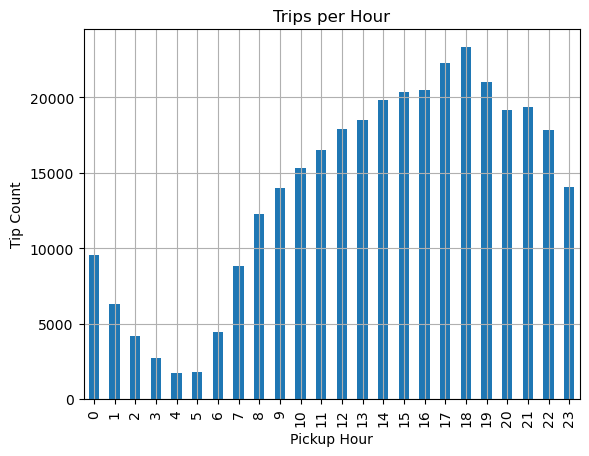

In [363]:
# Visualise the number of trips per hour and find the busiest hour
trips_per_hour_df = df1.groupby (['pickup_hour']).size ().reset_index ()
trips_per_hour_df.columns = ['pickup_hour', 'nb_trips']
trips_per_hour_df.plot.bar (x = 'pickup_hour', y = 'nb_trips', legend=False)
plt.title ('Trips per Hour')
plt.ylabel ("Tip Count")
plt.xlabel ("Pickup Hour")
plt.grid (True)
#plt.legend ()
plt.show ()

In [365]:
trips_per_hour_df[(trips_per_hour_df['nb_trips'] == trips_per_hour_df['nb_trips'].max ())]

pickup_hour  nb_trips
18           18     23333

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [369]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.01

trips_per_hour_df['nb_trips_upscaled'] = trips_per_hour_df['nb_trips'] / sample_fraction

max_five_trips_per_hour_df = trips_per_hour_df.nlargest (5, 'nb_trips_upscaled')

max_five_trips_per_hour_df['nb_trips_upscaled']

18    2333300.0
17    2226100.0
19    2098500.0
16    2049300.0
15    2037100.0
Name: nb_trips_upscaled, dtype: float64

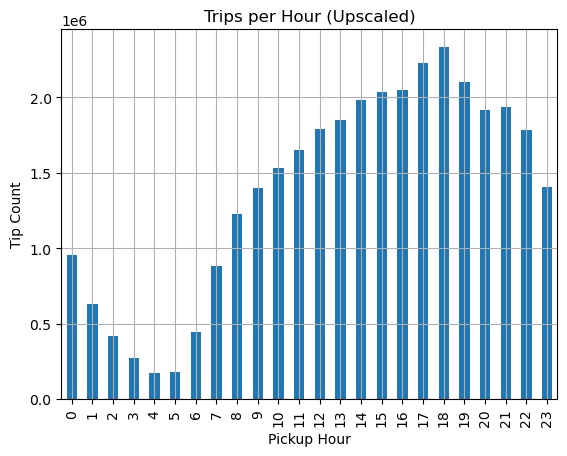

In [371]:
# Plot the upscaled trip
trips_per_hour_df.plot.bar (x = 'pickup_hour', y = 'nb_trips_upscaled', legend=False)
plt.title ('Trips per Hour (Upscaled)')
plt.ylabel ("Tip Count")
plt.xlabel ("Pickup Hour")
plt.grid (True)
plt.show ()

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

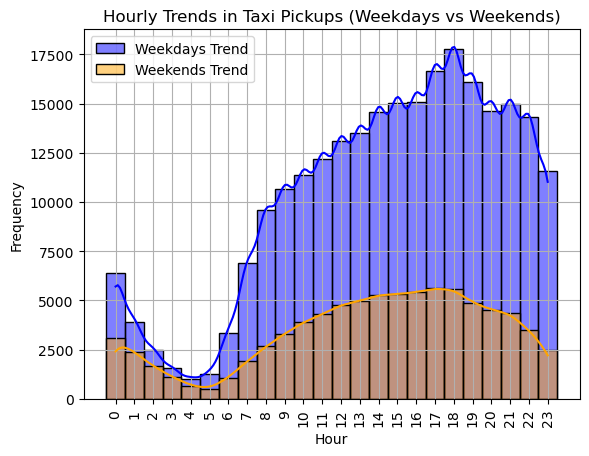

In [374]:
# Compare traffic trends for the week days and weekends
df1['weekdays'] = df1['pickup_week_day'].apply (lambda x : True if x >= 1 and x <= 5 else False)

inp0_weekdays_df = df1[df1['weekdays'] == True]
inp0_weekends_df = df1[df1['weekdays'] == False]

sns.histplot (data=inp0_weekdays_df, x="pickup_hour", discrete=True, color='blue', alpha=0.5, kde=True, label='Weekdays Trend')
h = sns.histplot (data=inp0_weekends_df, x="pickup_hour", discrete=True, color='orange', alpha=0.5, kde=True, label='Weekends Trend')

plt.title ('Hourly Trends in Taxi Pickups (Weekdays vs Weekends)')
plt.ylabel ("Frequency")
plt.xlabel ("Hour")
h.set_xticks ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
plt.xticks (rotation=90)
plt.grid (True)
plt.legend()
plt.show ()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [378]:
# Find top 10 pickup and dropoff zones
pickup_location_df = df1.groupby (['PUZone']).size ().reset_index ()

pickup_location_df.columns = ['PUZone', 'PickupCount']

max_ten_pickup_location_df = pickup_location_df.nlargest (10, 'PickupCount')

max_ten_pickup_location_df[['PUZone', 'PickupCount']]

PUZone  PickupCount
90                    JFK Airport        18492
120                Midtown Center        15463
178         Upper East Side South        15353
177         Upper East Side North        13678
99              LaGuardia Airport        12315
121                  Midtown East        12168
138  Penn Station/Madison Sq West        11758
103           Lincoln Square East        11067
171     Times Sq/Theatre District        10959
128                   Murray Hill         9934

In [380]:
dropoff_location_df = df1.groupby (['DOZone']).size ().reset_index ()

dropoff_location_df.columns = ['DOZone', 'DropoffCount']

max_ten_dropoff_location_df = dropoff_location_df.nlargest (10, 'DropoffCount')

max_ten_dropoff_location_df[['DOZone', 'DropoffCount']]

DOZone  DropoffCount
226      Upper East Side North         14409
227      Upper East Side South         13600
151             Midtown Center         12725
220  Times Sq/Theatre District         10088
160                Murray Hill          9936
132        Lincoln Square East          9633
152               Midtown East          9280
229      Upper West Side South          9162
131            Lenox Hill West          8619
63                East Chelsea          8554

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [383]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
zones_pickup_dropoff_count = pd.merge (left=zones, right=pickup_location_df, how='left', left_on='zone', right_on='PUZone')

zones_pickup_dropoff_count = pd.merge (left=zones_pickup_dropoff_count, right=dropoff_location_df, how='left', left_on='zone', right_on='DOZone')

zones_pickup_dropoff_count.drop (columns=['PUZone'], inplace=True)

zones_pickup_dropoff_count.drop (columns=['DOZone'], inplace=True)

zones_pickup_dropoff_count['PickupCount'].fillna (0, inplace=True)

zones_pickup_dropoff_count['DropoffCount'].fillna (0, inplace=True)

zones_pickup_dropoff_count.drop (zones_pickup_dropoff_count[(zones_pickup_dropoff_count['PickupCount'] == 0)].index, inplace=True)

zones_pickup_dropoff_count.drop (zones_pickup_dropoff_count[(zones_pickup_dropoff_count['DropoffCount'] == 0)].index, inplace=True)

zones_pickup_dropoff_count['PickupDropoffRatio'] = zones_pickup_dropoff_count['PickupCount'] / zones_pickup_dropoff_count['DropoffCount']

In [385]:
zones_pickup_dropoff_count.nlargest (10, 'PickupDropoffRatio')[['zone', 'PickupDropoffRatio']]

zone  PickupDropoffRatio
69                  East Elmhurst           10.953020
131                   JFK Airport            5.071860
137             LaGuardia Airport            2.986178
185  Penn Station/Madison Sq West            1.604750
113       Greenwich Village South            1.437578
42                   Central Park            1.360135
248                  West Village            1.345769
161                  Midtown East            1.311207
99               Garment District            1.237146
160                Midtown Center            1.215167

In [387]:
zones_pickup_dropoff_count.nsmallest (10, 'PickupDropoffRatio')[['zone', 'PickupDropoffRatio']]

zone  PickupDropoffRatio
0                         Newark Airport            0.006720
88                  Flatbush/Ditmas Park            0.007194
199  Riverdale/North Riverdale/Fieldston            0.007752
36                        Bushwick South            0.011494
134                    Kew Gardens Hills            0.012346
217            Springfield Gardens North            0.012821
256                      Windsor Terrace            0.013423
130                      Jamaica Estates            0.013889
172                         North Corona            0.014286
251                           Whitestone            0.014493

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [478]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
df1['night_hour'] = df1['pickup_hour'].apply (lambda x : True if x >= 23 or x <= 5 else False)

grouping = df1.groupby (['night_hour', 'PUZone']).size ().reset_index ()
night_grouping = grouping[grouping['night_hour'] == True]
night_grouping.columns = ['night_hour', 'PUZone', 'PUCount']
night_grouping.nlargest (10, 'PUCount')

night_hour                        PUZone  PUCount
229        True                  East Village     2872
254        True                   JFK Airport     2779
322        True                  West Village     2379
213        True                  Clinton East     1961
269        True               Lower East Side     1874
248        True       Greenwich Village South     1645
309        True     Times Sq/Theatre District     1536
291        True  Penn Station/Madison Sq West     1296
282        True                 Midtown South     1146
224        True                  East Chelsea     1131

In [482]:
grouping = df1.groupby (['night_hour', 'DOZone']).size ().reset_index ()
night_grouping = grouping[grouping['night_hour'] == True]
night_grouping.columns = ['night_hour', 'DOZone', 'DOCount']
night_grouping.nlargest (10, 'DOCount')

night_hour                         DOZone  DOCount
320        True                   East Village     1454
290        True                   Clinton East     1353
402        True                    Murray Hill     1159
343        True                       Gramercy     1058
309        True                   East Chelsea     1048
373        True                Lenox Hill West      986
491        True                 Yorkville West      952
477        True                   West Village      918
457        True  Sutton Place/Turtle Bay North      855
458        True      Times Sq/Theatre District      828

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [485]:
# Filter for night hours (11 PM to 5 AM)
day_hours_filtered_df = night_hours_df [night_hours_df['night_hour'] == False]

night_hours_filtered_df['total_amount'].sum ()

1182721.0899999999

In [489]:
day_hours_filtered_df['total_amount'].sum ()

8585802.149999997

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [495]:
# Analyse the fare per mile per passenger for different passenger counts
fare_per_mile_per_passenger_df = df1

fare_per_mile_per_passenger_df['fare_per_mile_per_passenger'] = fare_per_mile_per_passenger_df['total_amount'] / (
    fare_per_mile_per_passenger_df['passenger_count'] * fare_per_mile_per_passenger_df['trip_distance'])

fare_per_mile_per_passenger_df.groupby (['passenger_count'])['fare_per_mile_per_passenger'].describe ()

count       mean       std       min       25%        50%  \
passenger_count                                                                 
1.0              251819.0  11.836761  4.936576  0.600637  8.206311  11.091489   
2.0               52152.0   5.703525  2.568321  0.346847  3.829004   5.302632   
3.0               12861.0   3.858837  1.730657  0.901080  2.616257   3.585859   
4.0                7166.0   2.833498  1.274945  0.717601  1.886281   2.617235   
5.0                4427.0   2.308002  0.958864  0.702963  1.628982   2.158590   
6.0                2907.0   1.950597  0.761857  0.655454  1.374907   1.861702   

                       75%         max  
passenger_count                         
1.0              14.583333  128.173913  
2.0               7.078726   61.961538  
3.0               4.770370   49.859155  
4.0               3.500000   13.800000  
5.0               2.829139   15.300000  
6.0               2.380611    6.557377

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

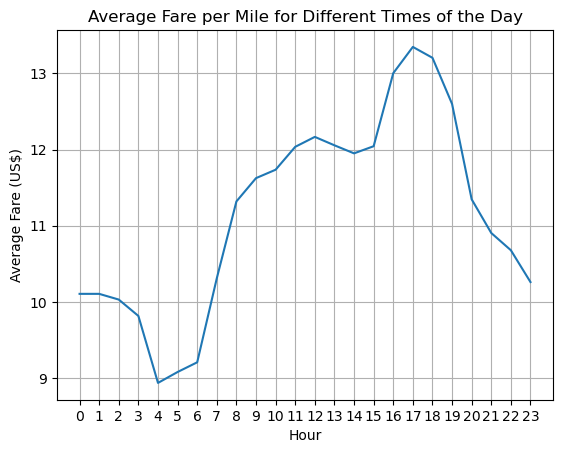

In [498]:
# Compare the average fare per mile for different days and for different times of the day
average_fare_per_mile_df = df1

average_fare_per_mile_df['average_fare_per_mile'] = average_fare_per_mile_df['total_amount'] / average_fare_per_mile_df['trip_distance']

h = average_fare_per_mile_df.groupby (['pickup_hour'])['average_fare_per_mile'].mean ().plot ()

h.set_xticks ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
plt.title ('Average Fare per Mile for Different Times of the Day')
plt.ylabel ("Average Fare (US$)")
plt.xlabel ("Hour")
plt.grid (True)
plt.show ()

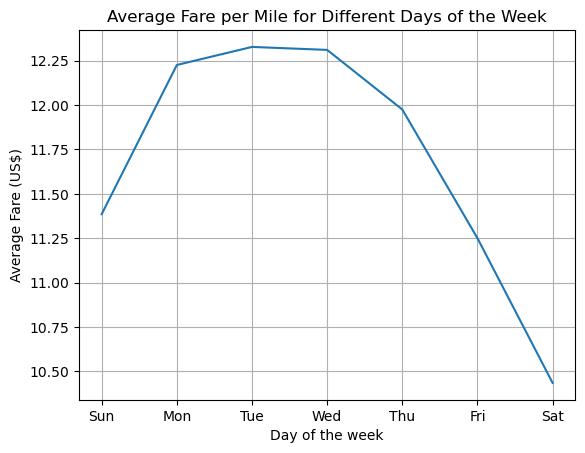

In [500]:
h = average_fare_per_mile_df.groupby (['pickup_week_day'])['average_fare_per_mile'].mean ().plot ()

h.set_xticks ([0, 1, 2, 3, 4, 5, 6])
plt.title ('Average Fare per Mile for Different Days of the Week')
plt.ylabel ("Average Fare (US$)")
plt.xlabel ("Day of the week")
h.set_xticks ([0, 1, 2, 3, 4, 5, 6])
h.set_xticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.grid (True)
plt.show ()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

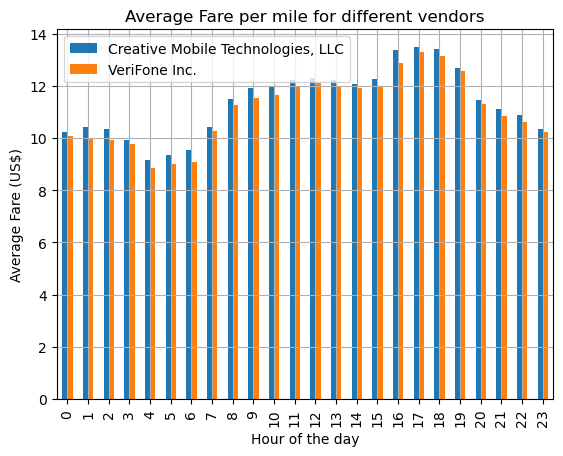

In [503]:
# Compare fare per mile for different vendors
ax = average_fare_per_mile_df.groupby (['VendorID', 'pickup_hour'])['average_fare_per_mile'].mean ().unstack ('VendorID').plot.bar ()

plt.title ('Average Fare per mile for different vendors')
plt.ylabel ("Average Fare (US$)")
plt.xlabel ("Hour of the day")
plt.grid (True)
ax.legend (["Creative Mobile Technologies, LLC", "VeriFone Inc."]);
plt.show ()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


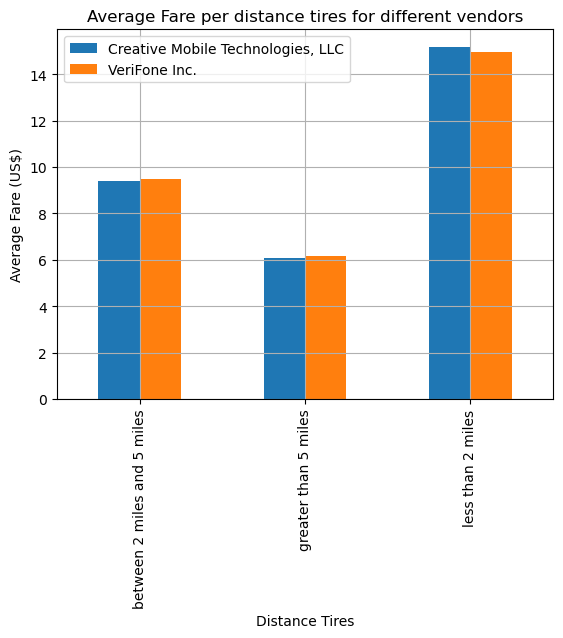

In [506]:
# Defining distance tiers
average_distance_tiers_df = df1

average_distance_tiers_df['distance_tires'] = average_fare_per_mile_df['trip_distance'].apply (lambda x: "less than 2 miles" if x < 2 else "between 2 miles and 5 miles" if x <= 5 else "greater than 5 miles")

ax = average_distance_tiers_df.groupby (['VendorID', 'distance_tires'])['average_fare_per_mile'].mean ().unstack ('VendorID').plot.bar ()

plt.title ('Average Fare per distance tires for different vendors')
plt.ylabel ("Average Fare (US$)")
plt.xlabel ("Distance Tires")
plt.grid (True)
ax.legend (["Creative Mobile Technologies, LLC", "VeriFone Inc."]);
plt.show ()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

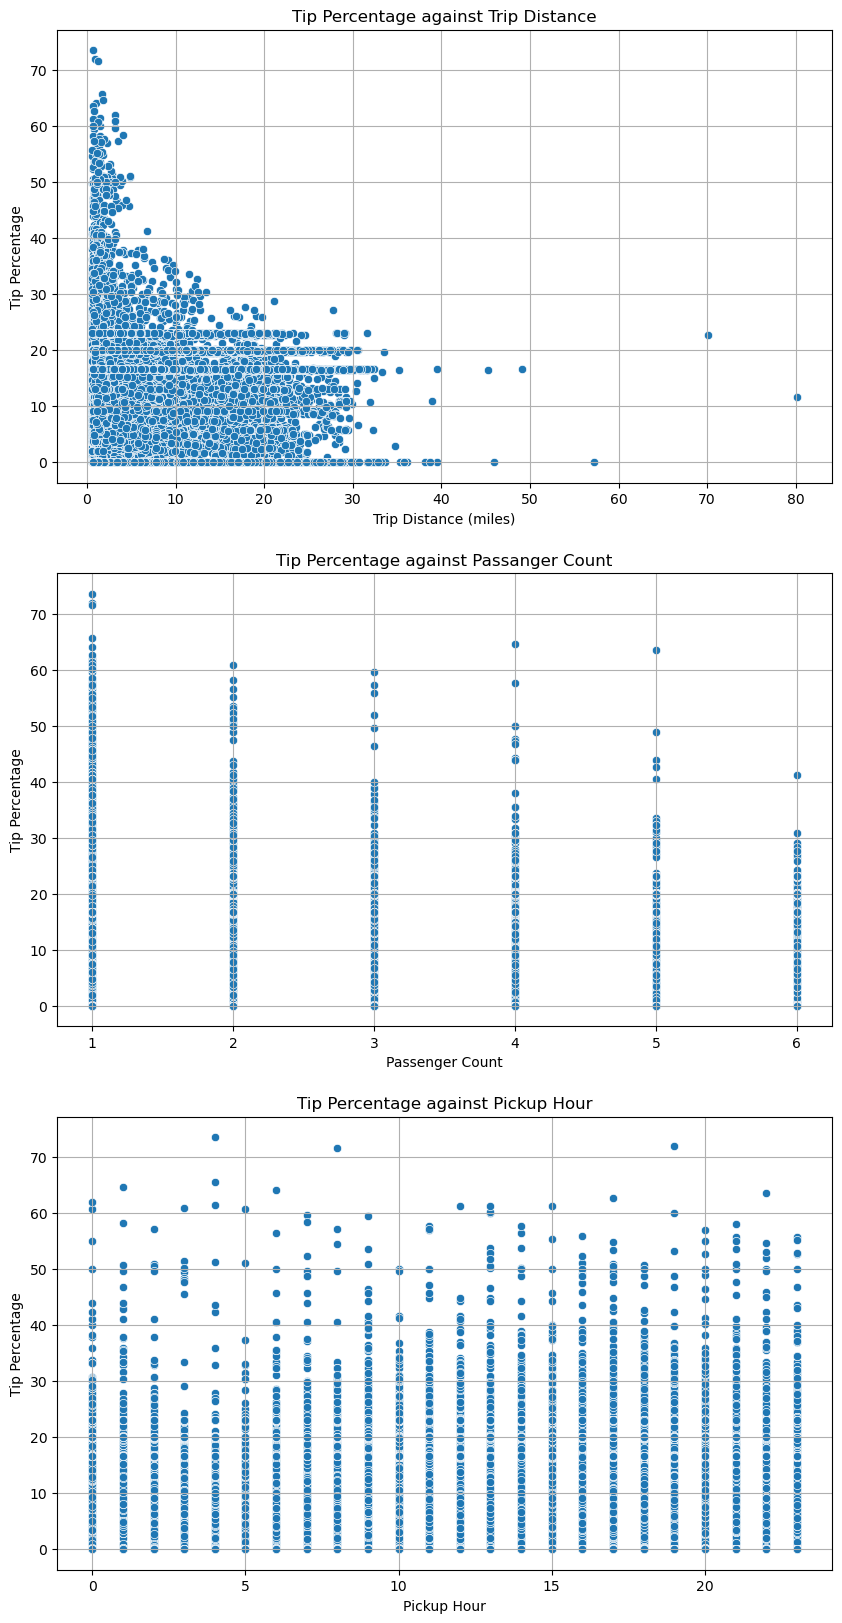

In [510]:
# Analyze tip percentages based on distances, passenger counts and pickup times
tip_percentage_df = df1

tip_percentage_df['tip_percentage'] = tip_percentage_df['tip_amount'] * 100.0 / tip_percentage_df['total_amount']

plt.figure (figsize=(10, 20))

plt.subplot (3, 1, 1)
sns.scatterplot (x="trip_distance", y="tip_percentage", data=tip_percentage_df);
plt.title ('Tip Percentage against Trip Distance')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Trip Distance (miles)")
plt.grid (True)

plt.subplot (3, 1, 2)
sns.scatterplot (x="passenger_count", y="tip_percentage", data=tip_percentage_df);
plt.title ('Tip Percentage against Passanger Count')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Passenger Count")
plt.grid (True)

plt.subplot (3, 1, 3)
sns.scatterplot (x="pickup_hour", y="tip_percentage", data=tip_percentage_df);
plt.title ('Tip Percentage against Pickup Hour')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Pickup Hour")
plt.grid (True)

plt.show ();

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

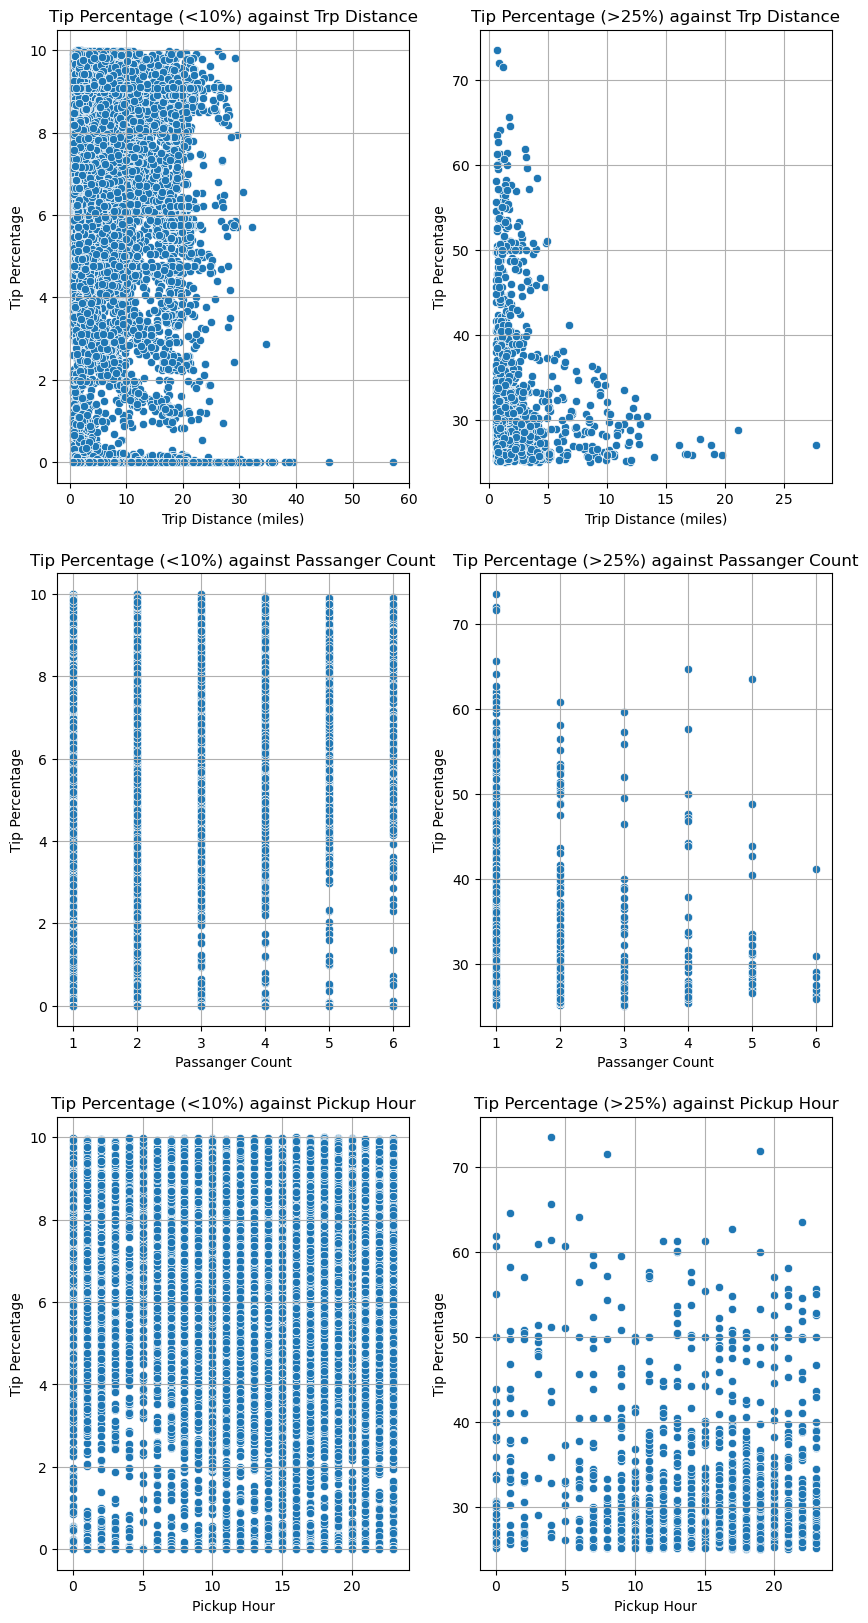

In [512]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

tip_less_10_percentage_df = tip_percentage_df[tip_percentage_df['tip_percentage'] < 10]

tip_more_25_percentage_df = tip_percentage_df[tip_percentage_df['tip_percentage'] > 25]

plt.figure (figsize=(10, 20))

plt.subplot (3, 2, 1)
sns.scatterplot (x="trip_distance", y="tip_percentage", data=tip_less_10_percentage_df);
plt.title ('Tip Percentage (<10%) against Trp Distance')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Trip Distance (miles)")
plt.grid (True)

plt.subplot (3, 2, 2)
sns.scatterplot (x="trip_distance", y="tip_percentage", data=tip_more_25_percentage_df);
plt.title ('Tip Percentage (>25%) against Trp Distance')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Trip Distance (miles)")
plt.grid (True)

plt.subplot (3, 2, 3)
sns.scatterplot (x="passenger_count", y="tip_percentage", data=tip_less_10_percentage_df);
plt.title ('Tip Percentage (<10%) against Passanger Count')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Passanger Count")
plt.grid (True)

plt.subplot (3, 2, 4)
sns.scatterplot (x="passenger_count", y="tip_percentage", data=tip_more_25_percentage_df);
plt.title ('Tip Percentage (>25%) against Passanger Count')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Passanger Count")
plt.grid (True)

plt.subplot (3, 2, 5)
sns.scatterplot (x="pickup_hour", y="tip_percentage", data=tip_less_10_percentage_df);
plt.title ('Tip Percentage (<10%) against Pickup Hour')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Pickup Hour")
plt.grid (True)

plt.subplot (3, 2, 6)
sns.scatterplot (x="pickup_hour", y="tip_percentage", data=tip_more_25_percentage_df);
plt.title ('Tip Percentage (>25%) against Pickup Hour')
plt.ylabel ("Tip Percentage")
plt.xlabel ("Pickup Hour")
plt.grid (True)

plt.show ();

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

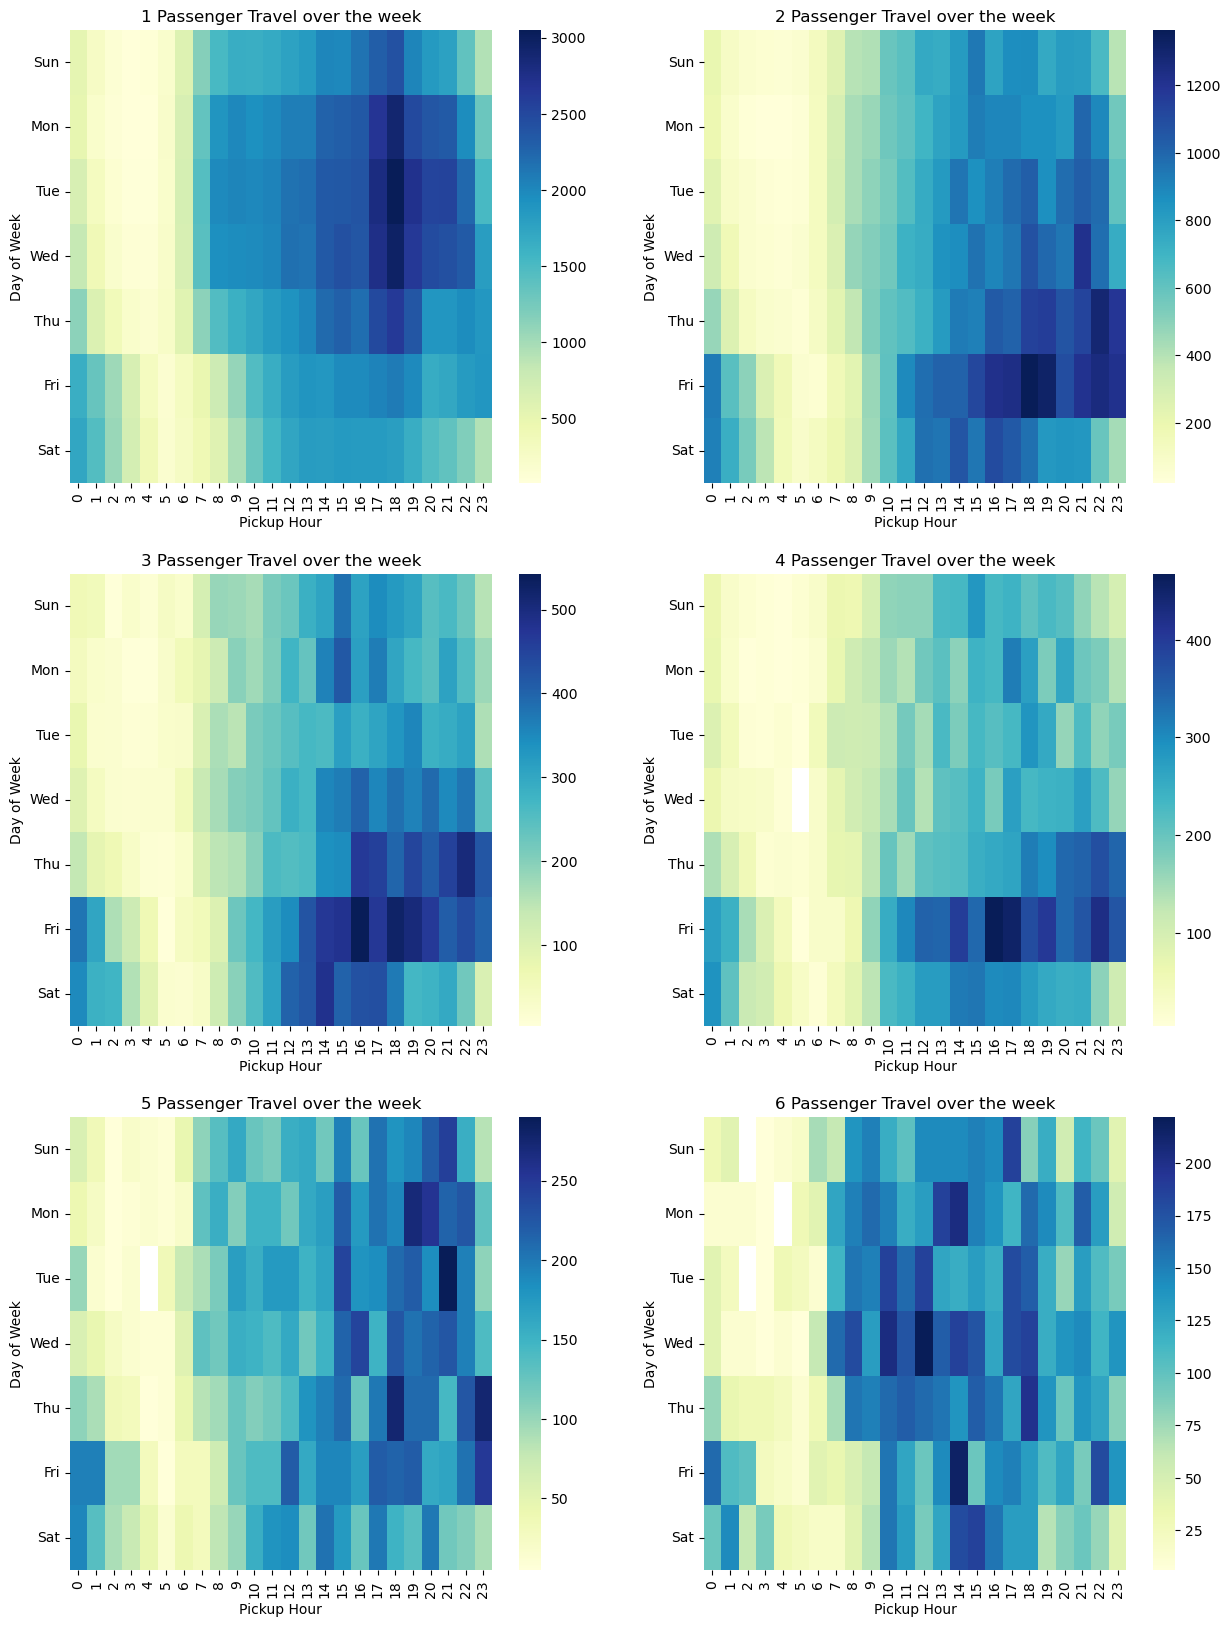

In [616]:
# See how passenger count varies across hours and days

plt.figure (figsize=(15, 20))

plt.subplot (3, 2, 1)
df1_passenger = df1[df1['passenger_count'] == 1]
grouping = df1_passenger.groupby (['pickup_week_day', 'pickup_hour'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.pivot_table (index="pickup_week_day", columns="pickup_hour", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('1 Passenger Travel over the week')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Hour")

plt.subplot (3, 2, 2)
df1_passenger = df1[df1['passenger_count'] == 2]
grouping = df1_passenger.groupby (['pickup_week_day', 'pickup_hour'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.pivot_table (index="pickup_week_day", columns="pickup_hour", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('2 Passenger Travel over the week')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Hour")

plt.subplot (3, 2, 3)
df1_passenger = df1[df1['passenger_count'] == 3]
grouping = df1_passenger.groupby (['pickup_week_day', 'pickup_hour'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.pivot_table (index="pickup_week_day", columns="pickup_hour", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('3 Passenger Travel over the week')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Hour")

plt.subplot (3, 2, 4)
df1_passenger = df1[df1['passenger_count'] == 4]
grouping = df1_passenger.groupby (['pickup_week_day', 'pickup_hour'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.pivot_table (index="pickup_week_day", columns="pickup_hour", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('4 Passenger Travel over the week')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Hour")

plt.subplot (3, 2, 5)
df1_passenger = df1[df1['passenger_count'] == 5]
grouping = df1_passenger.groupby (['pickup_week_day', 'pickup_hour'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.pivot_table (index="pickup_week_day", columns="pickup_hour", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('5 Passenger Travel over the week')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Hour")

plt.subplot (3, 2, 6)
df1_passenger = df1[df1['passenger_count'] == 6]
grouping = df1_passenger.groupby (['pickup_week_day', 'pickup_hour'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.pivot_table (index="pickup_week_day", columns="pickup_hour", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('6 Passenger Travel over the week')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Hour")

plt.show ()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

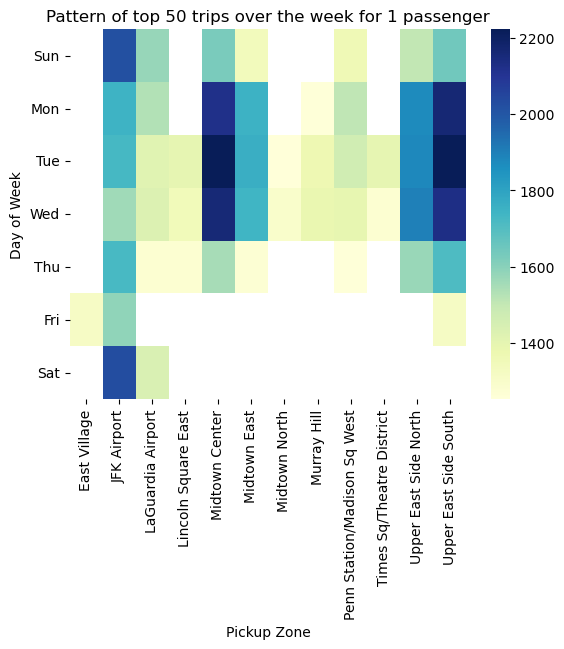

In [700]:
# How does passenger count vary across zones

df1_passenger = df1[df1['passenger_count'] == 1]
grouping = df1_passenger.groupby (['pickup_week_day', 'PUZone'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'passenger_count')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 trips over the week for 1 passenger')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

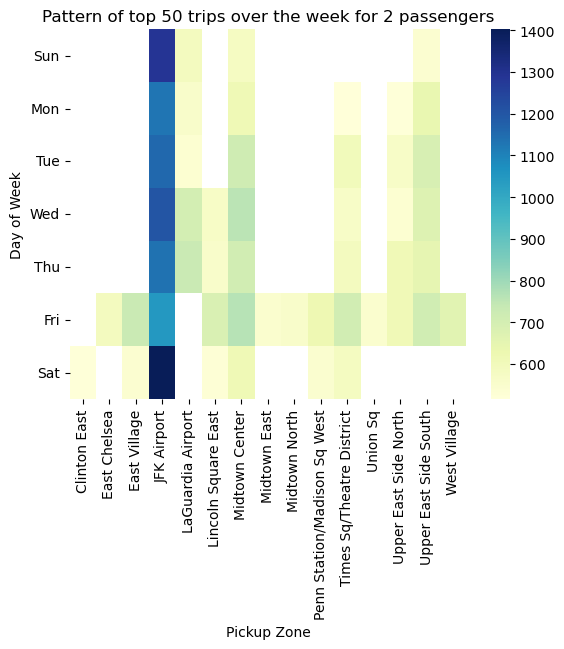

In [702]:
df1_passenger = df1[df1['passenger_count'] == 2]
grouping = df1_passenger.groupby (['pickup_week_day', 'PUZone'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'passenger_count')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 trips over the week for 2 passengers')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

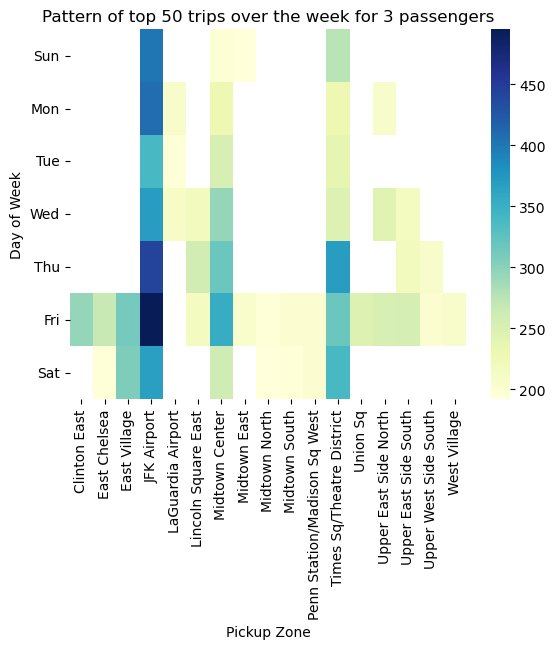

In [704]:
df1_passenger = df1[df1['passenger_count'] == 3]
grouping = df1_passenger.groupby (['pickup_week_day', 'PUZone'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'passenger_count')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 trips over the week for 3 passengers')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

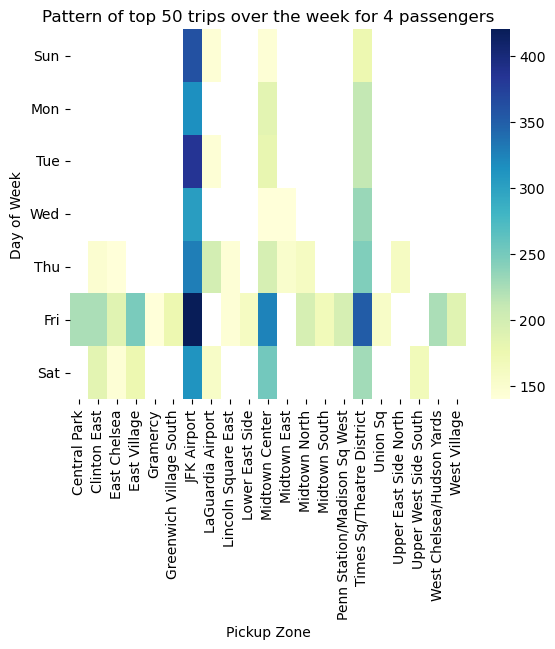

In [706]:
df1_passenger = df1[df1['passenger_count'] == 4]
grouping = df1_passenger.groupby (['pickup_week_day', 'PUZone'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'passenger_count')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 trips over the week for 4 passengers')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

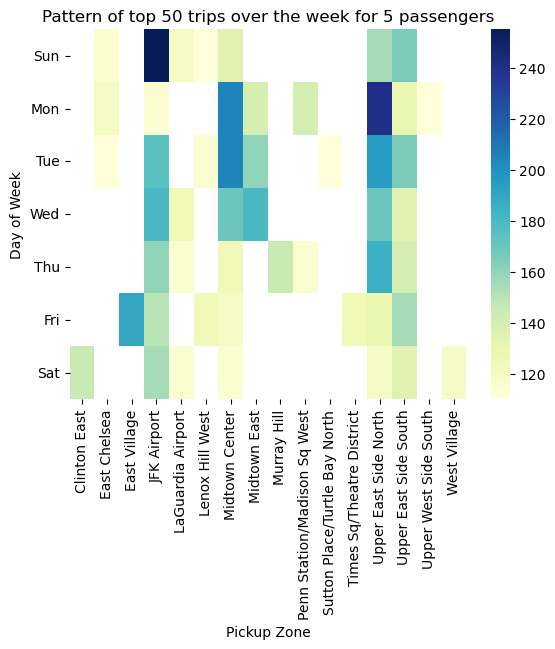

In [708]:
df1_passenger = df1[df1['passenger_count'] == 5]
grouping = df1_passenger.groupby (['pickup_week_day', 'PUZone'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'passenger_count')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 trips over the week for 5 passengers')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

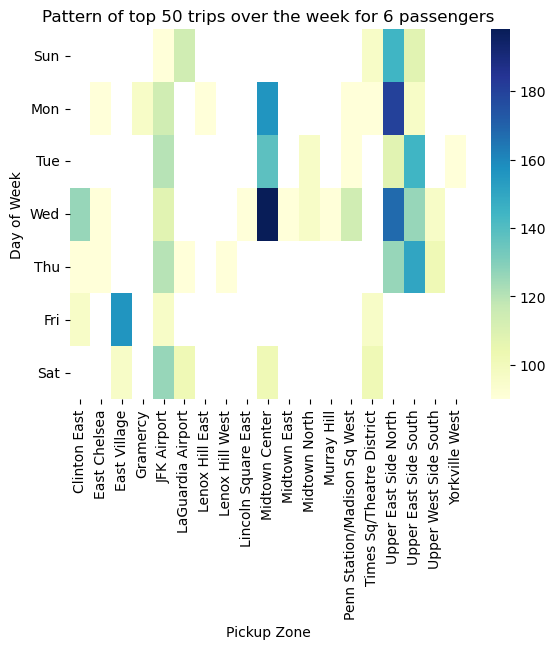

In [709]:
df1_passenger = df1[df1['passenger_count'] == 6]
grouping = df1_passenger.groupby (['pickup_week_day', 'PUZone'])['passenger_count'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'passenger_count')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="passenger_count")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 trips over the week for 6 passengers')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

In [715]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
zones.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', 'NbTrips'],
      dtype='object')

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

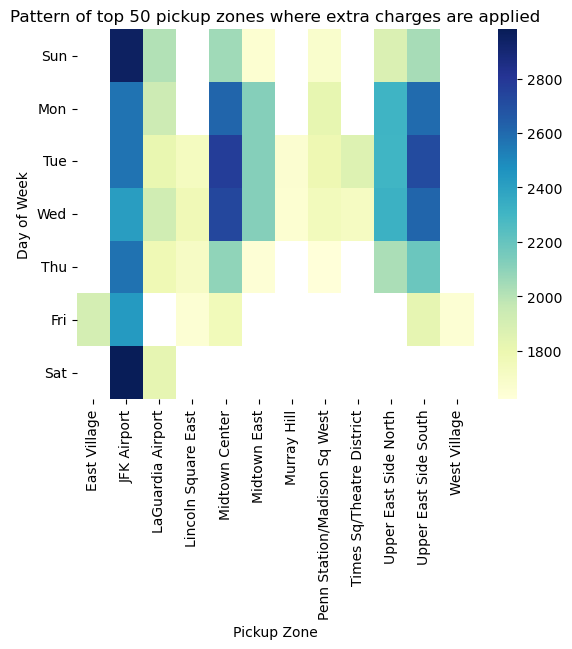

In [743]:
df1['extra_applied'] = (df1['extra'] != 0) | (df1['improvement_surcharge'] != 0) | (df1['congestion_surcharge'] != 0)
grouping = df1.groupby (['pickup_week_day', 'PUZone'])['extra_applied'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'extra_applied')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="PUZone", values="extra_applied")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 pickup zones where extra charges are applied')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Pickup Zone")
plt.xticks (rotation=90)
plt.show ()

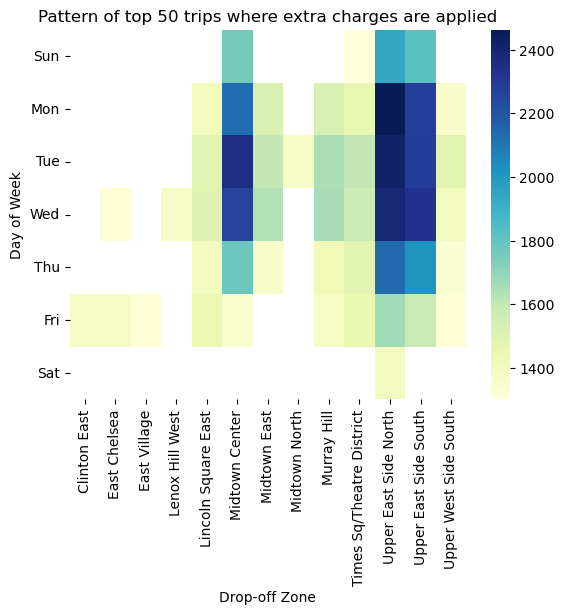

In [741]:
df1['extra_applied'] = (df1['extra'] != 0) | (df1['improvement_surcharge'] != 0) | (df1['congestion_surcharge'] != 0)
grouping = df1.groupby (['pickup_week_day', 'DOZone'])['extra_applied'].sum ().reset_index ()
grouping_df = grouping.nlargest (50, 'extra_applied')
grouping_df = grouping_df.pivot_table (index="pickup_week_day", columns="DOZone", values="extra_applied")
h = sns.heatmap (grouping_df, cmap="YlGnBu", annot=False, fmt="0.0f")
plt.title ('Pattern of top 50 drop-off zones where extra charges are applied')
plt.ylabel ("Day of Week")
plt.yticks (rotation=0)
h.set_yticklabels (["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel ("Drop-off Zone")
plt.xticks (rotation=90)
plt.show ()

In [ ]:
# How often is each surcharge applied?
plt.figure (figsize=(13, 20))
plt.subplot (1, 3, 1)
piv = pd.pivot_table (df1, values="extra", index=["PULocationID"], columns=["pickup_hour"], aggfunc='count', fill_value=0)
ax = sns.heatmap (piv, cbar=False, square=True)
plt.title ('Extra Charges')
plt.ylabel ("Zone ID")
plt.xlabel ("Pickup Hour")
plt.grid (True)

plt.subplot (1, 3, 2)
piv = pd.pivot_table (df1, values="improvement_surcharge", index=["PULocationID"], columns=["pickup_hour"], aggfunc='count', fill_value=0)
ax = sns.heatmap (piv, cbar=False, square=True)
plt.title ('Improvement Surcharge')
plt.ylabel ("Zone ID")
plt.xlabel ("Pickup Hour")
plt.grid (True)
          
plt.subplot (1, 3, 3)
piv = pd.pivot_table (df1, values="congestion_surcharge", index=["PULocationID"], columns=["pickup_hour"], aggfunc='count', fill_value=0)
ax = sns.heatmap (piv, cbar=False, square=True)
plt.title ('Congestion Surcharge')
plt.ylabel ("Zone ID")
plt.xlabel ("Pickup Hour")
plt.grid (True)

#plt.setp (ax.xaxis.get_majorticklabels (), rotation=90)
plt.tight_layout ()
plt.legend()
plt.show ()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

a)	The number of cabs in high demand area (as listed in section

b)	Slower routes during peak period maybe avoided and cabs maybe redirected to faster routes

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

a)	Position more cabs in high demand areas, especially during peak period

b)	Position cabs in zones having high pickup count

c)	Position cabs in zones having pickup drop ratio close to 1, this will ensure that cabs will likely not idle after drop-off

d)	High demands are observed during summer months (May to June) and during holiday seasons (October to December). Additional cabs maybe position around that time.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

a)	Discounts maybe offered during off peak hours to attract travel

b)	Fares maybe adjusted based on distance tiers. Shorter distance (which are more frequently opted) maybe competitively priced. For medium and longer trips, the fares maybe increased a bit.